<a href="https://colab.research.google.com/github/sagihaider/IADS_SC_2019/blob/master/TransferLearning_FeatureExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Upload data
from zipfile import ZipFile

file_name = "/content/drive/My Drive/data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


Install packages tensorflow 1.3.0 and keras 2.0.7

In [0]:
!pip install tensorflow==1.3.0
!pip install keras==2.0.7

     |████████████████████████████████| 43.6MB 876kB/s 
     |████████████████████████████████| 1.6MB 32.7MB/s 
     |████████████████████████████████| 890kB 39.6MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107223 sha256=603cf60a08a8b9502eeea695a520ccbe06bad454ec5112ab449dcb65cb7e3c7a
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: stable-baselines 2.2.1 has requirement tensorflow>=1.5.0, but you'll have tensorflow 1.3.0 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.3.0 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.0
    Uninstalling bleach-3.1.0:
      Successfully uninstalled bleach-3.1.0
  Found existing installation: tensorflow 1.14.0
    Unins

In [0]:
import numpy as np
import os
import time
from vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
#%% Load an elephant image as an example and see the image-processing

img_path = 'elephant.jpg' # image name
img = image.load_img(img_path, target_size=(224, 224)) # load image
x = image.img_to_array(img) # convert image to array
print (x.shape)
x = np.expand_dims(x, axis=0) # expand dimension
print (x.shape)
x = preprocess_input(x)
print('Input image shape:', x.shape)



(224, 224, 3)
(1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)


In [0]:
#%% Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)

In [0]:
img_data_list=[] # created an empty list for images to be loaded

for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
#		x = x/255
		# print('Input image shape:', x.shape)
		img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-cats

Loaded the images of dataset-dogs

Loaded the images of dataset-horses

Loaded the images of dataset-Humans

(808, 1, 224, 224, 3)
(1, 808, 224, 224, 3)
(808, 224, 224, 3)


In [0]:
# Define the number of classes
num_classes = 4
print(img_data.shape[0])
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['cats','dogs','horses','humans']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

print(X_train.shape)
print(X_test.shape)


808
(646, 224, 224, 3)
(162, 224, 224, 3)


In [0]:
image_input = Input(shape=(224, 224, 3)) # shape of a single image

model = VGG16(input_tensor=image_input, 
              include_top=True,
              weights='imagenet') # load VGG-16 model with 'top = true'

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, 
            activation='softmax', 
            name='output')(last_layer)

custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False

custom_vgg_model.summary()

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
t=time.time()
#	t = now()
hist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=2, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 646 samples, validate on 162 samples
Epoch 1/2
646/646 [==============================] - 1158s - loss: 0.0125 - acc: 0.9969 - val_loss: 0.0806 - val_acc: 0.9815
Epoch 2/2
646/646 [==============================] - 1149s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0783 - val_acc: 0.9815
Training time: -2307.4774265289307
162/162 [==============================] - 232s   
[INFO] loss=0.0783, accuracy: 98.1481%


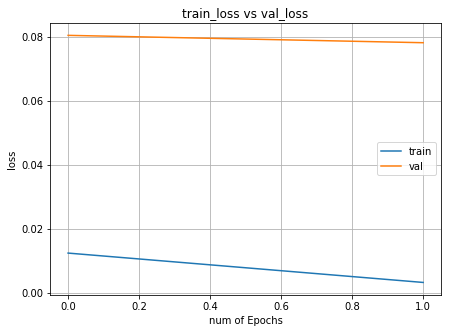

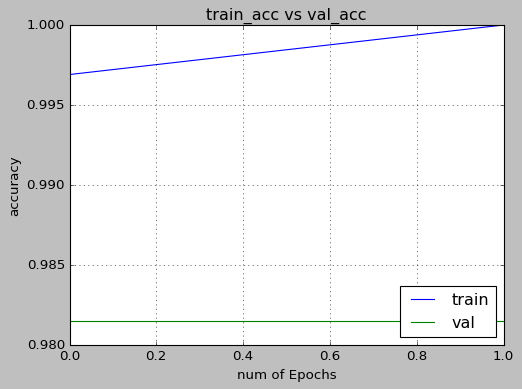

In [0]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(2)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])